<br/><font size="6"><b>Sbermarket. User's next order. </b></font>.<br/>

# Description of the project

## Formulation of the problem

In this competition, participants are asked to solve the problem of predicting the next user order (regardless of the specific moment in time when this order will occur). A user's order consists of a list of unique product categories, regardless of how many products of each category they have taken.


## Description of data

#### The train.csv training sample consists of the following columns:

* user_id - unique user id
* order_completed_at - order date
* cart - list of unique categories (category_id) that the order consisted of

As a prediction, for each user-category pair, return 1 if the category will be present in the user's next order, or 0 otherwise. The list of categories for each user contains all the categories that he has ever ordered.

#### Sample_submission.csv submission example:
Not all users from the training data are included in the test, as some of them did not order anything after the cutoff date.

* id - row identifier - consists of user_id and category_id separated by a semicolon: f'{user_id};{category_id}'.

*Due to the peculiarities of the Kaggle InClass checking system, it is not possible to use the user_id, category_id columns as an index separately*
* target - 1 or 0 - whether this category will be present in the user's next order


## Metrics

The evaluation metric for this competition is FScoreBeta with beta = 1, which gives a regular F1-Score. 
The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives 𝑡𝑝 to all predicted positives 𝑡𝑝+𝑓𝑝. Recall is the ratio of true positives to all actual positives 𝑡𝑝+𝑓𝑛. 

The F1 score is given by:
' 𝐹1=2𝑝⋅𝑟𝑝+𝑟  where  𝑝=𝑡𝑝𝑡𝑝+𝑓𝑝,  𝑟=𝑡𝑝𝑡𝑝+𝑓𝑛 '

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other

# Research approaches

In this project three approaches were used, which gave different results.

* ***First approach. Purchase predictions based on individual purchases and purchase information in general.***

Line example:

| user_id | cart | visit_number | median_carts_number | median_days_before_visit | target |
| ------------- |:-------------:| -----:| -----:|-----:|-----:|
| 0 | 1| 3 |16| 29| 0|

Learning and prediction based on decision trees.

*This approach showed the worst results. The accuracy on the validation and test set is about 0.02.
Therefore, its calculation is excluded from this file.*

* ***The second approach was based on predicting the entire set of purchases at once.***

Product data was grouped by purchases and converted to a positional format.
Training and prediction were made on multi-outputs (based on decision trees)

Line example:

| user_id      | cart          | visit_number  | median_carts_number  | median_days_before_visit  | d_roll | c_roll | targets(0,1,2.. )  |
| ------------- |:-------------:| -----:| -----:|-----:|-----:|-----:|-----:|
| 0    | 1| 3 |16| 29| 0|16| 29| 1,0,0...|


***This approach showed better results than the previous one. The accuracy on the test sample is up to 0.38.
In the future, it is possible to improve performance by adding new features. However, this approach is probably not suitable for a significant improvement in predictions***

* ***The third approach was taken as an idea*** [TIFU-KNN](https://docviewer.yandex.ru/view/325118343/?page=1&*=VglfYk6qLBS6PyxwoRL9OFaESVF7InVybCI6Imh0dHBzOi8vYXJ4aXYub3JnL3BkZi8yMDA2LjAwNTU2LnBkZiIsInRpdGxlIjoiMjAwNi4wMDU1Ni5wZGYiLCJub2lmcmFtZSI6dHJ1ZSwidWlkIjoiMzI1MTE4MzQzIiwidHMiOjE2MzE2NDcxNzcyMzcsInl1IjoiNzE0NzU2OTEyMTYxMDYzNjI0MyIsInNlcnBQYXJhbXMiOiJ0bT0xNjMxNjQ2ODcwJnRsZD1ydSZsYW5nPWVuJm5hbWU9MjAwNi4wMDU1Ni5wZGYmdGV4dD10aWZ1K2tubiZ1cmw9aHR0cHMlM0EvL2FyeGl2Lm9yZy9wZGYvMjAwNi4wMDU1Ni5wZGYmbHI9MjEzJm1pbWU9cGRmJmwxMG49cnUmc2lnbj02MmU4MTFhZTFkMDZjMDBmMTk1ZWJlYWVjZDQwZGZiMSZrZXlubz0wIn0=&lang=en)

    * A profile of each buyer was compiled. One line - his entire shopping experience.
    * A calculation was made of how many times each product was bought.
    * Purchases by a single user ranked from newest to oldest. At each stage, the data was weighted by the "forgetting factor".
    * Next, the nearest neighbors were found (according to the proximity of the vectors) and based on the rating of the purchases of the client and his nearest neighbors (they were weighted based on the distance), a list of probable goods for purchase was compiled.
    * When choosing the quantity of goods, the last number of purchased goods in the basket is taken as the basis.

Line example:

| user_id | 0(cart count) | 1 | 2 | ... |n |
| ------------- |:-------------:| -----:| -----:|-----:|-----:|
| 0 | 0.34| 3 |1 |...| 10|

***This approach showed good results (0.44 on the test set).
In the future, it is possible to improve the indicators by selecting the weight coefficients of "forgetting", the number of neighbors and their weight when calculating the final rating.***

<a name="1common."></a>
## <a name="0.0"></a>Content:
* [0. Loading libraries and self-written functions](#0.)
* [1. Data analysis and processing](#1.)
* [2. Approach: Predicting an entire set of purchases at once](#2.)
* [3. Approach: One Line - Entire Shopping Experience (TIFU-KNN)](#3.)

<aname="0."></a><br/>
<font size="5"><b>0. Loading libraries and self-written functions</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

In [248]:
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score

from sklearn.preprocessing import OneHotEncoder

from scipy import spatial

from sklearn.preprocessing import StandardScaler
from termcolor import colored

In [233]:
#Define the bold
def bold():
    return "\033[1m"

def bold_end():
    return "\033[0m"

#Set the format for numbers
pd.options.display.float_format = '{:>10.2f}'.format

#Remove warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [234]:
#**Function print_basic_info, to display information about the array and its variables.**

#* base - database name
#* info - 1: output information about the array, other: no output
#* describe - 1: output description of array variables, other: no output
#* duplicat - 1: print the number of full duplicates
#* head - n: base example output (output n - lines), n < 1: no output

def print_basic_info(base, info, describe, duplicate, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print(base.info())
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicate == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())
        
        
def diff(first, second):
    return [item for item in first if item not in second]

<a name="1."></a><br/>
<font size="5"><b>1. Data analysis and processing</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

In [235]:
contest_train = pd.read_csv('datasets/train.csv', sep=',',decimal='.', parse_dates = ['order_completed_at'])
sample_submission = pd.read_csv('datasets/sample_submission.csv', sep=',',decimal='.')

In [236]:
print_basic_info(sample_submission,1,0,1,3)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB
None

  head 


,id,target
0,0;133,0
1,0;5,1
2,0;10,0



  duplicated  

0


In [237]:
print_basic_info(contest_train,1,0,1,3)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB
None

  head 


,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198



  duplicated  

0


**The base consists of 3123064 cases**

There are no duplicates.

* It is not very clear how many purchases.
* At the same time, it is not very clear how many clients.
This must be calculated.

Plus, see how many customers buy products and how often. In every purchase.
We will probably use rolling mines for the last few purchases.

It would also be interesting what things the client usually buys together.
You can also try to see the things that are bought most often

*** Find out information about the number of products and baskets ***

In [238]:
gb_orders = contest_train.groupby(['user_id','order_completed_at']).agg({'cart': ('count')})
gb_orders = gb_orders.rename(columns={"cart": "count_cards"})
gb_orders.reset_index().head()

,user_id,order_completed_at,count_cards
0,0,2020-07-19 09:59:17,8
1,0,2020-08-24 08:55:32,25
2,0,2020-09-02 07:38:25,11
3,1,2019-05-08 16:09:41,1
4,1,2020-01-17 14:44:23,6


In [239]:
mgb_m = gb_orders.groupby(['user_id']).agg({'count_cards': ('median')})
mgb_m = mgb_m.rename(columns={"count_cards": "count_median"})

gb_orders = gb_orders.reset_index().merge(mgb_m, on=['user_id'], how='left')

gb_orders.head()

,user_id,order_completed_at,count_cards,count_median
0,0,2020-07-19 09:59:17,8,11.00
1,0,2020-08-24 08:55:32,25,11.00
2,0,2020-09-02 07:38:25,11,11.00
3,1,2019-05-08 16:09:41,1,3.00
4,1,2020-01-17 14:44:23,6,3.00


In [240]:
display(gb_orders.groupby(['user_id']).agg({'count_cards': ['count','median']}).describe())

count_cards           
            count     median
count    20000.00   20000.00
mean        10.47      14.00
std         11.91       6.59
min          3.00       1.00
25%          4.00       9.50
50%          6.00      13.00
75%         12.00      17.50
max        213.00      79.00

In total, the median number of orders is 6, and items on order are 13.00

*** Find out how often they order ***

In [37]:
s = ['user_id','order_completed_at']
diff_time = contest_train.drop_duplicates(subset = ['user_id','order_completed_at'])
diff_time = diff_time[s].sort_values(by = ['user_id','order_completed_at'])

diff_time['shift_order'] = diff_time['order_completed_at'].shift()
diff_time['first_order'] =  diff_time.sort_values(['user_id','order_completed_at'], ascending=[True,True]) \
             .groupby(['user_id']) \
             .cumcount() + 1
diff_time['shift_order'] = diff_time['shift_order'].where(diff_time['first_order'] !=1 , None)

diff_time['last_order'] =  diff_time.sort_values(['user_id','order_completed_at'], ascending=[False,False]) \
             .groupby(['user_id']) \
             .cumcount() + 1

diff_time['day_diff'] = (diff_time['order_completed_at'] - diff_time['shift_order']) / np.timedelta64(1,'D')

diff_time = diff_time.drop('shift_order', axis =1)
#diff_time = diff_time.set_index(s)
diff_time 

,user_id,order_completed_at,first_order,last_order,day_diff
2422913,0,2020-07-19 09:59:17,1,3,nan
2965135,0,2020-08-24 08:55:32,2,2,35.96
3097178,0,2020-09-02 07:38:25,3,1,8.95
65467,1,2019-05-08 16:09:41,1,9,nan
709747,1,2020-01-17 14:44:23,2,8,253.94
...,...,...,...,...,...
3079873,19998,2020-09-01 08:12:32,2,2,1.83
3106843,19998,2020-09-02 15:03:23,3,1,1.29
3074014,19999,2020-08-31 18:54:24,1,3,nan
3074378,19999,2020-08-31 19:32:08,2,2,0.03


In [249]:
diff_time = diff_time.merge(diff_time.groupby(['user_id']).agg({'day_diff' : 'median'}).reset_index() , on = 'user_id')
diff_time = diff_time.rename(columns={"day_diff_y": "day_median"})

diff_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209406 entries, 0 to 209405
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   user_id             209406 non-null  int64         
 1   order_completed_at  209406 non-null  datetime64[ns]
 2   first_order         209406 non-null  int64         
 3   last_order          209406 non-null  int64         
 4   day_diff_x          189406 non-null  float64       
 5   day_median          209406 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 11.2 MB


In [250]:
display(diff_time['day_median'].describe())

count    209406.00
mean         13.82
std          18.89
min           0.00
25%           5.95
50%           8.66
75%          14.74
max         866.43
Name: day_median, dtype: float64

**Let's see what's up with the dates**

2015-03-22 09:25:46 2020-09-03 23:45:45 2020-07-14 04:50:22


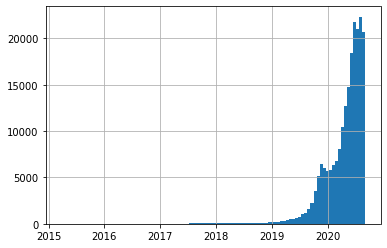

In [252]:
contest_train.drop_duplicates(subset = ['order_completed_at'])['order_completed_at'].hist(bins = 100)

print(contest_train['order_completed_at'].min(), contest_train['order_completed_at'].max(), 
      contest_train['order_completed_at'].quantile(0.75))

In [253]:
contest_train = contest_train.set_index(['order_completed_at'])

There is a tail up to the age of 19. It is better to remove it and leave only the data with the current behavior.

In [254]:
contest_train = contest_train.reset_index()
contest_train

contest_train = contest_train[contest_train['order_completed_at'] > '2019-01-01' ]

<a name="2."></a><br/>
<font size="5"><b>2. Approach: Predicting the entire set of purchases at once</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)


### Data processing.

Convert Cart data to positional

In [255]:
dumm = pd.get_dummies(contest_train['cart'])

In [256]:
contest_train_card = contest_train.join(dumm)

Group by orders

In [257]:
t= contest_train_card.groupby(['user_id','order_completed_at'])

cl = contest_train_card.iloc[:,4:].columns.to_list()

pivot_content = t.agg({0:('sum')})

In [258]:
for  i in cl:
    f = t.agg({i:('sum')})
    pivot_content = pivot_content.join(f)
    
pivot_content = pivot_content.reset_index()

merge feachers

In [259]:
#tmp_contest_train = contest_train.set_index(['user_id','order_completed_at'])
db_train  = contest_train.merge(diff_time, on=['order_completed_at', 'user_id'], how='right')

db_train = db_train.merge(gb_orders.reset_index(), on=['order_completed_at', 'user_id'], how='right')
db_train


new_id = db_train.drop_duplicates(subset=['user_id','cart'])

prepare base 

In [265]:
t = sample_submission['id'].str.split(';', expand=True)
#len(t[0].drop_duplicates())
#len(t[1].drop_duplicates())

def diff(first, second):
    return [item for item in first if item not in second]

#есть в wire, но нет в bulk
diff_id = diff(new_id['user_id'].drop_duplicates().values, t[0].astype('int64').drop_duplicates().values)

len(diff_id)

t =['user_id','cart']
new_id_s =new_id.query('user_id not in @diff_id')[t]

In [267]:
o = ['order_completed_at', 'user_id','cart']
tmp = db_train[o]
tmp['target'] = 1

In [268]:
base_new = new_id_s.merge(diff_time.query('user_id not in @diff_id')[s], 
               on=['user_id'], how='right').sort_values(by = ['user_id','cart'])
base_new=base_new.rename(columns={"order_completed_at_y": "order_completed_at"})
base_new=base_new.merge(tmp, on=['order_completed_at', 'user_id','cart'], how='left')
base_new['target'] = base_new['target'].fillna(0)

base_new=base_new.merge(diff_time, on=['order_completed_at', 'user_id'], how='left')
base_new=base_new.merge(gb_orders, on=['order_completed_at', 'user_id'], how='left')
base_new

,user_id,cart,order_completed_at,target,first_order,last_order,day_diff_x,day_median,count_cards,count_median
0,0,5.00,2020-07-19 09:59:17,0.00,1,3,nan,22.45,8,11.00
1,0,5.00,2020-08-24 08:55:32,1.00,2,2,35.96,22.45,25,11.00
2,0,5.00,2020-09-02 07:38:25,0.00,3,1,8.95,22.45,11,11.00
3,0,10.00,2020-07-19 09:59:17,0.00,1,3,nan,22.45,8,11.00
4,0,10.00,2020-08-24 08:55:32,1.00,2,2,35.96,22.45,25,11.00
...,...,...,...,...,...,...,...,...,...,...
13663493,19998,420.00,2020-09-01 08:12:32,1.00,2,2,1.83,1.56,7,7.00
13663494,19998,420.00,2020-09-02 15:03:23,0.00,3,1,1.29,1.56,4,7.00
13663495,19998,798.00,2020-08-30 12:15:55,0.00,1,3,nan,1.56,8,7.00
13663496,19998,798.00,2020-09-01 08:12:32,0.00,2,2,1.83,1.56,7,7.00


Let's add lines for what we will predict

In [270]:
#tmp_contest_train = contest_train.set_index(['user_id','order_completed_at'])
db_base  = pivot_content.merge(diff_time, on=['order_completed_at', 'user_id'], how='left')

db_base = db_base.merge(gb_orders.reset_index(), on=['order_completed_at', 'user_id'], how='left')
db_base

,user_id,order_completed_at,0,1,2,4,5,6,7,8,...,878,879,880,first_order,last_order,day_diff_x,day_median,index,count_cards,count_median
0,0,2020-07-19 09:59:17,0,0,0,0,0,0,0,0,...,0,0,0,1,3,nan,22.45,0,8,11.00
1,0,2020-08-24 08:55:32,0,0,0,0,1,0,0,0,...,0,0,0,2,2,35.96,22.45,1,25,11.00
2,0,2020-09-02 07:38:25,0,0,0,0,0,0,0,0,...,0,0,0,3,1,8.95,22.45,2,11,11.00
3,1,2019-05-08 16:09:41,0,0,0,0,0,0,0,0,...,0,0,0,1,9,nan,24.18,3,1,3.00
4,1,2020-01-17 14:44:23,0,0,0,0,0,0,0,0,...,0,0,0,2,8,253.94,24.18,4,6,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206979,19998,2020-09-01 08:12:32,0,0,0,0,0,1,0,0,...,0,0,0,2,2,1.83,1.56,209401,7,7.00
206980,19998,2020-09-02 15:03:23,0,0,0,0,0,0,0,0,...,0,0,0,3,1,1.29,1.56,209402,4,7.00
206981,19999,2020-08-31 18:54:24,0,0,0,0,0,0,0,0,...,0,0,0,1,3,nan,0.03,209403,1,1.00
206982,19999,2020-08-31 19:32:08,0,0,0,0,0,0,0,0,...,0,0,0,2,2,0.03,0.03,209404,1,1.00


In [271]:

t_tr = db_base.drop_duplicates(subset=['user_id'], keep='last')
t_tr['first_order'] = t_tr['first_order'] + 1
t = sample_submission['id'].str.split(';', expand=True)
len(t[0].drop_duplicates())
g = t[0].drop_duplicates()
t_tr = t_tr.query('user_id in @g')
t_tr['order_completed_at'] = t_tr['order_completed_at']  + np.timedelta64(1,'Y')
par = ['user_id','order_completed_at','first_order', 'day_median', 'count_median']
t_tr[par]

,user_id,order_completed_at,first_order,day_median,count_median
2,0,2021-09-02 13:27:37,4,22.45,11.00
11,1,2021-07-14 16:10:10,10,24.18,3.00
26,3,2021-06-24 18:56:41,8,50.01,2.00
33,4,2021-08-27 19:44:00,9,19.63,15.00
44,5,2021-08-29 15:46:08,16,12.24,5.00
...,...,...,...,...,...
206968,19994,2021-09-03 19:01:40,6,1.48,7.00
206971,19995,2021-08-30 20:46:48,4,0.16,3.00
206974,19996,2021-09-02 13:34:39,4,1.49,5.00
206977,19997,2021-08-31 17:37:35,4,0.51,17.00


Merge and make a single base

In [272]:
db_base = db_base.append(t_tr[par])
db_base

db_base = db_base.sort_values(by = ['user_id','order_completed_at'])
db_base['d_roll'] = db_base['day_diff_x'].rolling(2, min_periods=1).mean()
db_base['c_roll'] = db_base['count_cards'].rolling(2, min_periods=1).mean()
db_base['d_roll'] = db_base['d_roll'].where(db_base['first_order'] !=1 , None)
db_base['c_roll'] = db_base['c_roll'].where(db_base['first_order'] !=1 , None)
db_base


,user_id,order_completed_at,0,1,2,4,5,6,7,8,...,880,first_order,last_order,day_diff_x,day_median,index,count_cards,count_median,d_roll,c_roll
0,0,2020-07-19 09:59:17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1,3.00,nan,22.45,0.00,8.00,11.00,None,None
1,0,2020-08-24 08:55:32,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,2,2.00,35.96,22.45,1.00,25.00,11.00,35.96,16.50
2,0,2020-09-02 07:38:25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,3,1.00,8.95,22.45,2.00,11.00,11.00,22.45,18.00
2,0,2021-09-02 13:27:37,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,4,nan,nan,22.45,nan,nan,11.00,8.95,11.00
3,1,2019-05-08 16:09:41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1,9.00,nan,24.18,3.00,1.00,3.00,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206980,19998,2020-09-02 15:03:23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,3,1.00,1.29,1.56,209402.00,4.00,7.00,1.56,5.50
206980,19998,2021-09-02 20:52:35,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,4,nan,nan,1.56,nan,nan,7.00,1.29,4.00
206981,19999,2020-08-31 18:54:24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1,3.00,nan,0.03,209403.00,1.00,1.00,None,None
206982,19999,2020-08-31 19:32:08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2,2.00,0.03,0.03,209404.00,1.00,1.00,0.03,1.00


In [ ]:
#временные сохранения
#db_base.to_csv('/kaggle/working/db_base.csv', index=True)
#base_new = pd.read_csv('/kaggle/working/db_base.csv', sep=',',decimal='.', parse_dates = ['order_completed_at'])


Let's break it down into validation and training data.
Let's take 15% of the time.
We will take the first order for each person after

In [273]:
base_new = db_base
t = sample_submission['id'].str.split(';', expand=True)
len(t[0].drop_duplicates())

13036

In [274]:
g = t[0].astype('int').drop_duplicates().to_list()
base_new = base_new.query('user_id in @g')
base_new = base_new.dropna(subset=[0,'c_roll'])

In [275]:
train = base_new[base_new['order_completed_at'] < base_new['order_completed_at'].quantile(0.85) ]
test = base_new[base_new['order_completed_at'] >= base_new['order_completed_at'].quantile(0.85) ]

print(train['order_completed_at'].min(), train['order_completed_at'].max())
print(test['order_completed_at'].min(), test['order_completed_at'].max())

2019-01-01 07:26:02 2020-08-11 11:50:06
2020-08-11 11:52:06 2020-09-03 23:45:45


In [276]:
# Clean up the validation database

tmp_test = test.drop_duplicates(subset=['user_id','order_completed_at'])
tmp_test['order'] = tmp_test.sort_values(['user_id','order_completed_at'], ascending=[True,True]) \
             .groupby(['user_id']) \
             .cumcount() + 1

ts = ['user_id','order_completed_at','order']
tmp_test[ts]
test = test.merge(tmp_test[ts], on=['order_completed_at', 'user_id'], how='left')

test = test[test['order'] == 1]
test = test[test['first_order'] != 1]

test

,user_id,order_completed_at,0,1,2,4,5,6,7,8,...,first_order,last_order,day_diff_x,day_median,index,count_cards,count_median,d_roll,c_roll,order
0,0,2020-08-24 08:55:32,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,2,2.00,35.96,22.45,1.00,25.00,11.00,35.96,16.50,1
2,4,2020-08-27 13:54:48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,8,1.00,67.28,19.63,41.00,11.00,15.00,43.46,10.00,1
3,5,2020-08-16 15:37:08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,13,3.00,17.00,12.24,54.00,1.00,5.00,15.42,1.00,1
6,8,2020-08-19 06:23:55,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,8,1.00,30.80,45.00,85.00,24.00,39.00,37.90,30.50,1
7,9,2020-08-16 09:03:48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,43,4.00,53.77,10.63,128.00,8.00,7.00,86.02,11.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21913,19994,2020-08-29 09:09:10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2,4.00,0.03,1.48,209387.00,6.00,7.00,0.03,7.50,1
21917,19995,2020-08-30 14:51:42,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2,2.00,0.31,0.16,209392.00,5.00,3.00,0.31,4.00,1
21919,19996,2020-08-30 08:35:57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2,2.00,0.01,1.49,209395.00,5.00,5.00,0.01,7.00,1
21921,19997,2020-08-31 11:04:05,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2,2.00,0.99,0.51,209398.00,1.00,17.00,0.99,12.50,1


In [277]:
params = ['user_id','first_order', 'day_median', 'count_median','d_roll', 'c_roll']
#params = ['user_id','first_order', 'day_median', 'count_median']

train and test on the validation set (last time slice)

DecisionTreeClassifier

In [289]:
train.iloc[:,2:878]

,0,1,2,4,5,6,7,8,9,10,...,871,872,873,874,875,876,877,878,879,880
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205986,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
205990,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
206059,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
206099,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [279]:
model = MultiOutputClassifier(DecisionTreeClassifier()).fit(train[params], train.iloc[:,2:878])
t = model.predict(test[params])

In [292]:
f_b = pd.DataFrame()
n = 0

for c in train.iloc[:,2:878].columns.to_list():
    tmp = pd.DataFrame()
    tmp['target'] = test.iloc[:, 2 + n]
    tmp['predict'] = t[:,n]
    tmp['user_id'] = test['user_id']
    tmp['cart'] =  c
    f_b = pd.concat([f_b, tmp])
    n = n + 1;

In [293]:
f_b

,target,predict,user_id,cart
0,0.00,0.00,0,0
2,0.00,0.00,4,0
3,0.00,0.00,5,0
6,0.00,1.00,8,0
7,0.00,0.00,9,0
...,...,...,...,...
21913,0.00,0.00,19994,880
21917,0.00,0.00,19995,880
21919,0.00,0.00,19996,880
21921,0.00,0.00,19997,880


KNeighborsClassifier 

In [297]:

#model2 = MultiOutputClassifier(KNeighborsClassifier()).fit(train[params], train.iloc[:,2:878])
#t2 = model2.predict(test[params])


In [298]:

#f_b = pd.DataFrame()
#n = 0

#for c in train.iloc[:,2:878].columns.to_list():
#    tmp = pd.DataFrame()
#    tmp['target'] = test.iloc[:, 3 + n]
#    tmp['predict'] = t2[:,n]
#    tmp['user_id'] = test['user_id']
#    tmp['cart'] =  c
#    f_b = pd.concat([f_b, tmp])
#    n = n + 1;


fbeta_score

In [299]:
#DecisionTreeClassifier
fbeta_score(f_b['target'], f_b['predict'],  beta=1)
#посмотрим скорр. не плохо. 0.24

0.24631539448880105

In [300]:
#KNeighborsClassifier
#fbeta_score(f_b['target'], f_b['predict'],  beta=1)

final model MultiOutputClassifier(DecisionTreeClassifier())

In [307]:
db_base = db_base.dropna(subset=[0,'c_roll'])

In [308]:
# обучим на всех данных
#model.fit(db_base[params], db_base.iloc[:,2:878])

#удалим лишние кейсы и предскажем 
#t_tr = db_base.drop_duplicates(subset=['user_id'], keep='last')
#t_tr['first_order'] = t_tr['first_order'] + 1
#t = sample_submission['id'].str.split(';', expand=True)
#len(t[0].drop_duplicates())
#g = t[0].drop_duplicates()
#t_tr = t_tr.query('user_id in @g')

#t = model.predict(t_tr[params])

convert the database to the required format

In [309]:
#f_b = pd.DataFrame()
#n = 0

#for c in train.iloc[:,2:883].columns.to_list():
#    tmp = pd.DataFrame()
#    tmp['user_id'] = t_tr['user_id']
#    tmp['predict'] = t[:,n]
    
#    tmp['cart'] =  c
#    f_b = pd.concat([f_b, tmp])
#    n = n + 1;

#f_b

In [310]:
# удалим лишнее
#f = sample_submission['id'].to_list()


#f_b['target'] = f_b['predict'].astype('int')
#f_b['id'] = (f_b['user_id'].astype('str') + ';' + f_b['cart'].astype('str'))
#f_b2 = f_b.query('id in @f')


In [311]:
#Проверим что не потеряли кейсы
#len(f_b2)

In [312]:
#len(sample_submission)

<a name="3."></a><br/>
<font size="5"><b>3. Approach: One line - the whole shopping experience (TIFU-KNN).</b></font>.<br/>
[<font size="2">(to content)</font>](#1common.)

prepare database

In [313]:
db_base  = pivot_content.merge(diff_time, on=['order_completed_at', 'user_id'], how='left')
db_base = db_base.merge(gb_orders.reset_index(), on=['order_completed_at', 'user_id'], how='left')
db_base[0].sum()

18114

In [314]:
db_base.iloc[:,3:878].head()

,1,2,4,5,6,7,8,9,10,11,...,871,872,873,874,875,876,877,878,879,880
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [315]:
#db_base.iloc[:,2:878] = db_base.iloc[:,2:878] / db_base['last_order']

for i in range(2,878):
    db_base.iloc[:,i]= db_base.iloc[:,i] / db_base['last_order']

In [316]:
cl = contest_train_card.iloc[:,4:877].columns.to_list()

t = db_base.groupby(['user_id'])
pivot_content2 = t.agg({0:('sum')})

In [318]:
pivot_content2.head()

,0
user_id,
0,0.00
1,0.00
2,0.08
3,0.00
4,0.00


In [ ]:
# долгий расчет
for i in cl:
    f = t.agg({i:('sum')})
    pivot_content2 = pivot_content.join(f)

In [ ]:
# промежуточное сохранение
#pivot_content2.to_csv('db_base.csv', index=True)

In [12]:
pivot_content_after = pd.read_csv('db_base.csv', sep=',',decimal='.', index_col = 'user_id')

In [15]:
t = sample_submission['id'].str.split(';', expand=True)
len(t[0].drop_duplicates())
g = t[0].astype('int').drop_duplicates().to_list()
pivot_content_after = pivot_content_after.query('user_id in @g')

In [16]:
# отнормируем вектора

St = StandardScaler()
St.fit(pivot_content_after)

StandardScaler()

In [17]:
ssp = St.transform(pivot_content_after)

In [18]:
ssp = pd.DataFrame(ssp)

In [20]:
# To find similar vectors make a tree
tree = spatial.cKDTree(ssp)

In [192]:
# example
tree.query(ssp.iloc[k,1:875].to_list(),10)

(array([ 0.        , 12.04667466, 12.08491953, 12.21035762, 12.23619875,
        12.32724286, 12.34896785, 12.38101965, 12.40426499, 12.40452763]),
 array([    0, 12134,  7352,   846,  7146, 12468,  6753,  6609,  7298,
         5338]))

In [201]:
ssp.iloc[k,[1,800]]

0          -0.54
799        -0.61
Name: 0, dtype: float64

Let's find neighbors, make a rating and create a base from it.
#the calculation is very long

In [ ]:
results = pd.DataFrame()

k = 0

for n in pivot_content_after.index.values[0:]:
    # take 4 neighbors
    tree_query = tree.query(ssp.iloc[k,1:875].to_list(),5)
    tree_query = pd.DataFrame(tree_query).T
    tree_query = tree_query.set_axis(['dist', 'index'], axis=1)
    # range no more than 15
    tree_query = tree_query[tree_query['dist'] < 15]
    # calculation of weights
    tree_query['weight'] = (16 - tree_query['dist'])
    # edit indexes a bit
    tree_query =tree_query.merge(ssp[{'index','user_id'}], on = 'index', how = 'inner')
    tree_query = tree_query.merge(gb_orders.drop_duplicates(subset = 'user_id', keep = 'last'),
                                  on = 'user_id' , how='inner')
    tree_query =tree_query.merge(pivot_content_after, on = 'user_id')
    # the weight
    for i in range(6,880):
        tree_query.iloc[:,i]= tree_query.iloc[:,i] * tree_query['weight']
    
    tmp = tree_query.iloc[:,6:880].sum()
    tmp = tmp.sort_values(ascending=False)
    tmp = tmp.head(int(tree_query['count_cards'][0]))
    #When choosing the quantity of goods, the last quantity of previously purchased goods is taken as the basis
    one_id = pd.DataFrame(tmp.index.values, columns=['cart'])
    one_id['user_id']= int(tree_query['user_id'][0])
    one_id['target'] = 1
    results = results.append(one_id)
    # counter
    k = k+1
    print(13036 - (k))

In [242]:
#  save
results.to_csv('results2.csv', index=True)

In [243]:
#   unique count
len(results['user_id'].unique())

13030

In [245]:
# merge with sample_submission and fill gaps with 0

results['id'] = (results['user_id'].astype('str') + ';' + results['cart'].astype('str'))
results2 = results.drop_duplicates(subset='id')

In [281]:
output =  sample_submission.drop('target', axis=1).merge(results2 , on = 'id', how ='left').fillna(0)
output['target'] = output['target'].astype('int')

#### Export predictions on the test set

In [282]:
output2 = pd.DataFrame({'id': output['id'], 
                       'target': output['target']})

output2.to_csv('sub_kiseleva4.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
